### Análisis de Comentarios de Twitter

In [1]:
#Mo
# Importamos las librerías

import re
import nltk
import pandas as pd
from datetime import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from nltk.tokenize import RegexpTokenizer

import gensim
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

###Diccionarios en español para el análisis de polaridad
nltk.download('punkt')
# Tokenización
# Descargar el conjunto de stopwords en español si no lo tienes
nltk.download('stopwords')
# Análisis de polaridad
# Obtención de listado de stopwords del inglés
stop_words = list(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /home/cygnus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/cygnus/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df_coments_a = pd.read_csv("twitter_coments_lomeli.csv", usecols=["css-901oao 4"])
df_coments_b = pd.read_csv("twitter_coments_lomeli_3.csv", usecols=["css-901oao 8"])

# Renombramos la columnas

df_coments_a = df_coments_a.rename(columns={"css-901oao 4": "texto"})
df_coments_b = df_coments_b.rename(columns={"css-901oao 8": "texto"})
df_coments = pd.concat([df_coments_a, df_coments_b])
df_coments = df_coments.dropna()
df_coments['texto'] = df_coments['texto'].str.lower()
df_coments.to_csv("coments_x.csv")

In [3]:
import re

def limpiar_texto(texto):
    # Eliminar caracteres especiales y números
    texto_limpio = re.sub(r'[^\w\sáéíóúüÁÉÍÓÚÜñ]', '', texto, flags=re.UNICODE)
    # Eliminar espacios en blanco adicionales y convertir a minúsculas
    texto_limpio = ' '.join(texto_limpio.split()).lower()
    return texto_limpio

df_coments["texto"] = df_coments["texto"].apply(limpiar_texto)
df_coments['texto'] = df_coments['texto'].str.lower()
tokenizer = RegexpTokenizer(r'\w+')
df_coments['tokens'] = df_coments['texto'].apply(nltk.tokenize.word_tokenize)
df_coments.to_csv("posts_x.csv")
df_coments

,texto,tokens
0,la encuestadora,"[la, encuestadora]"
1,aquí ni pío dicen,"[aquí, ni, pío, dicen]"
2,4,[4]
3,de que sirven la guardia nacional y el ejércit...,"[de, que, sirven, la, guardia, nacional, y, el..."
4,jalisco está con el mejor con el doctor carlos...,"[jalisco, está, con, el, mejor, con, el, docto..."
...,...,...
538,a él no le toca es regidor en guadalajara,"[a, él, no, le, toca, es, regidor, en, guadala..."
539,mintiendo hasta en eso,"[mintiendo, hasta, en, eso]"
540,dice desconozco los que las pintaron pero se l...,"[dice, desconozco, los, que, las, pintaron, pe..."
541,entonces usted por su propia mano borrelos,"[entonces, usted, por, su, propia, mano, borre..."


In [4]:
# Eliminacion de Stopwords

# Limpieza de Stop_words
stop_words.extend(("q", "d", "van", "si", "pa", "así", "ser", "solo", "tan", "va", "as", "aquí", "hacia","dra", "día","hoy","dd","drcarloslomeli","jajaja"
                "le", "con","ella", "qué", "por", "qu", "ers", "das", "ve", "jajaja", "jeje", "La", "nimo", "ms", "da","doccast","vas","jajajaja",
                "drcarloslomeli", "doc", "dr", "jajajajajajaja", "vez"))

##########NUBE DE PALABRAS
def preprocess_text(text):
    words = text # Tokenizar y convertir a minúsculas
    words = [word for word in words if word.isalpha()]  # Eliminar caracteres no alfabéticos
    words = [word for word in words if word not in stop_words]  # Eliminar palabras vacías
    return words


preprocessed_text = df_coments["tokens"].apply(preprocess_text)

preprocessed_text

0                                         [encuestadora]
1                                           [pío, dicen]
2                                                     []
3      [sirven, guardia, nacional, ejército, sirve, m...
4               [jalisco, mejor, doctor, carlos, lomelí]
                             ...                        
538                         [toca, regidor, guadalajara]
539                                          [mintiendo]
540       [dice, desconozco, pintaron, agradezco, ánimo]
541            [entonces, usted, propia, mano, borrelos]
542    [junta, likes, post, resulta, gaste, dinero, b...
Name: tokens, Length: 1131, dtype: object

In [5]:
# Unimos todas las listas de palabras en una sola lista
all_words = [word for sublist in preprocessed_text.values for word in sublist]

# Creamos un DataFrame con las palabras y sus frecuencias
word_counts = pd.Series(all_words).value_counts()

# Tomamos las palabras más comunes (puedes ajustar este valor según tus necesidades)
top_words = word_counts.head(10)
top_words.to_csv("top_words_coments.csv")

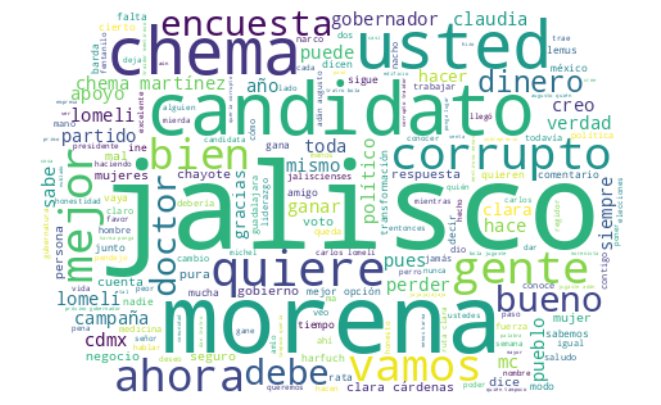

In [6]:
import numpy as np
# Unir las palabras en un solo texto (separadas por espacios)
texto = " ".join(all_words)
# Cículo
x, y = np.ogrid[:300, :500]
mask = (x - 150) ** 2 + (y - 250) ** 2 > 230 ** 2
mask = 255 * mask.astype(int)
# Crear el objeto WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white", mask=mask).generate(texto)
# Mostrar la nube de palabras utilizando matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Desactivar ejes
plt.savefig("nube_palabras_coments.png", dpi=300)
plt.show()

## Topicos y Temas Emergentes

In [7]:
import spacy

nlp = spacy.load("es_core_news_sm")

# Función para preprocesar el texto
def preprocess_text(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]

# Aplicar el preprocesamiento a cada fila del DataFrame
df_coments['texto_preprocesado'] = df_coments.texto.apply(preprocess_text)
df_coments

,texto,tokens,texto_preprocesado
0,la encuestadora,"[la, encuestadora]",[encuestadora]
1,aquí ni pío dicen,"[aquí, ni, pío, dicen]",[pío]
2,4,[4],[]
3,de que sirven la guardia nacional y el ejércit...,"[de, que, sirven, la, guardia, nacional, y, el...","[servir, guardia, nacional, ejército, servir, ..."
4,jalisco está con el mejor con el doctor carlos...,"[jalisco, está, con, el, mejor, con, el, docto...","[jalisco, doctor, carlos, lomelí]"
...,...,...,...
538,a él no le toca es regidor en guadalajara,"[a, él, no, le, toca, es, regidor, en, guadala...","[tocar, regidor, guadalajara]"
539,mintiendo hasta en eso,"[mintiendo, hasta, en, eso]",[mentir]
540,dice desconozco los que las pintaron pero se l...,"[dice, desconozco, los, que, las, pintaron, pe...","[desconozco, pintar, agradecer, ánimo]"
541,entonces usted por su propia mano borrelos,"[entonces, usted, por, su, propia, mano, borre...","[mano, borre él]"


In [8]:
# Generación de bigramas con spaCy
nlp = spacy.load("es_core_news_sm")

def generar_bigramas_spacy(texto):
    doc = nlp(texto)
    bigramas = [(doc[i].text, doc[i + 1].text) for i in range(len(doc) - 1)]
    return bigramas

df_coments['bigramas_spacy'] = df_coments['texto'].apply(generar_bigramas_spacy)


In [9]:
from nltk.collocations import *

flatten_corpus = [w for l in df_coments.bigramas_spacy for w in l]

treshold = 3

bigrams = [bigram for bigram in flatten_corpus if len(bigram[0])>treshold and len(bigram[1])>treshold]

In [10]:
bigram_measure = nltk.collocations.BigramAssocMeasures()
finder = BigramCollocationFinder.from_documents(bigrams)
finder.apply_freq_filter(2)
colocaciones = finder.nbest(bigram_measure.pmi, 20)
colocaciones

[('abogada', 'esquivel'),
 ('alta', 'responsabilidad'),
 ('alto', 'cargo'),
 ('arde', 'asta'),
 ('asiento', 'saber'),
 ('caro', 'cuernoschuecos'),
 ('cesar', 'duarte'),
 ('comas', 'ancias'),
 ('desafortunado', 'silencio'),
 ('excelente', 'inicio'),
 ('frangie', 'artos'),
 ('fuerzas', 'reales'),
 ('jajajjaj', 'pelagatos'),
 ('jarocha', 'pendejø'),
 ('memes', 'hiram'),
 ('mexicanos', 'secuestrados'),
 ('power', 'ranking'),
 ('prestigio', 'cucharero'),
 ('quieran', 'pretendan'),
 ('sector', 'agropecuario')]

In [11]:
# Función para lematizar el texto
def lematizar_texto(texto):
    doc = nlp(texto)
    lemas = [token.lemma_ for token in doc]
    return " ".join(lemas)

# Aplicar la función de lematización a cada fila del DataFrame
df_coments['texto_lematizado'] = df_coments.texto.apply(lematizar_texto)
df_coments

,texto,tokens,texto_preprocesado,bigramas_spacy,texto_lematizado
0,la encuestadora,"[la, encuestadora]",[encuestadora],"[(la, encuestadora)]",el encuestadora
1,aquí ni pío dicen,"[aquí, ni, pío, dicen]",[pío],"[(aquí, ni), (ni, pío), (pío, dicen)]",aquí ni pío decir
2,4,[4],[],[],4
3,de que sirven la guardia nacional y el ejércit...,"[de, que, sirven, la, guardia, nacional, y, el...","[servir, guardia, nacional, ejército, servir, ...","[(de, que), (que, sirven), (sirven, la), (la, ...",de que servir el guardia nacional y el ejércit...
4,jalisco está con el mejor con el doctor carlos...,"[jalisco, está, con, el, mejor, con, el, docto...","[jalisco, doctor, carlos, lomelí]","[(jalisco, está), (está, con), (con, el), (el,...",jalisco estar con el mejor con el doctor carlo...
...,...,...,...,...,...
538,a él no le toca es regidor en guadalajara,"[a, él, no, le, toca, es, regidor, en, guadala...","[tocar, regidor, guadalajara]","[(a, él), (él, no), (no, le), (le, toca), (toc...",a él no él tocar ser regidor en guadalajara
539,mintiendo hasta en eso,"[mintiendo, hasta, en, eso]",[mentir],"[(mintiendo, hasta), (hasta, en), (en, eso)]",mentir hasta en ese
540,dice desconozco los que las pintaron pero se l...,"[dice, desconozco, los, que, las, pintaron, pe...","[desconozco, pintar, agradecer, ánimo]","[(dice, desconozco), (desconozco, los), (los, ...",decir desconozco el que él pintar pero él él a...
541,entonces usted por su propia mano borrelos,"[entonces, usted, por, su, propia, mano, borre...","[mano, borre él]","[(entonces, usted), (usted, por), (por, su), (...",entonces usted por su propio mano borre él


In [12]:
# eliminar la función ner para acelerar el procesamiento
nlp.disable_pipes('ner')

from tqdm import tqdm

# dataset
dataset = df_coments['texto_lematizado']
docs = []
for text in tqdm(nlp.pipe(dataset), total=len(dataset)):
    doc = nlp(text) 
    pt = [token.lemma_.lower() for token in doc if
           (len(token.lemma_) > 1 and token.pos_ == "NOUN" and 
          not token.is_stop)]
    docs.append(pt)

docs

100%|██████████████████████████████████████| 1131/1131 [00:04<00:00, 228.26it/s]


[[],
 ['pío'],
 [],
 ['ejército', 'priista'],
 ['doctor'],
 ['entrevista'],
 [],
 ['juicio', 'ovidio', 'red', 'corrupto'],
 ['proyecto'],
 ['año', 'mujer', 'video'],
 [],
 [],
 ['honesto', 'íntegro', 'gracia', 'doc'],
 ['respeto',
  'confianza',
  'persona',
  'honestidad',
  'integridad',
  'labor',
  'inicio',
  'semana'],
 ['respeto',
  'confianza',
  'persona',
  'honestidad',
  'integridad',
  'labor',
  'inicio',
  'semana'],
 [],
 ['ejército'],
 [],
 ['objetivo',
  'dinero',
  'lugar',
  'amigo',
  'negocio',
  'verificación',
  'precandidato',
  'morena'],
 ['amigo', 'doctor'],
 ['lana'],
 ['dr'],
 ['2024'],
 [],
 [],
 [],
 ['felicidad', 'suerte', 'gán', 'boca', 'bot'],
 ['sobreprecio', 'adjudicación'],
 [],
 ['semana'],
 ['cárdena'],
 ['exacto', 'candidato'],
 ['soldado', 'transformación', 'jalisco'],
 ['ejecución'],
 ['tiempo', 'doctor'],
 [],
 ['región'],
 ['lucha', 'corrupción'],
 ['horario'],
 ['liderazgo', 'militante', 'simpatizante'],
 ['gente', 'apoyo', 'región', 'produ

In [13]:
from collections import Counter
from itertools import chain

counts_word_occurence = Counter(chain(*[x for x in docs]))

# Palabras con una sola ocurrencia
low_freq_words = {key:value for (key,value) in counts_word_occurence.items() if value==1}
docs = [[lemma for lemma in text if counts_word_occurence[lemma]>0] for text in docs]

In [14]:
docs_length=len(docs)
# calculate in how many documents a word appeared
counts_word_percentage = Counter(chain(*[set(x) for x in docs]))

# calculate in what % of all articles a word appears
counts_word_percentage = {key:(value/docs_length)*100 for (key,value) in counts_word_percentage.items()}
high_freq_words = {key:value for (key,value) in counts_word_percentage.items() if value>1}

high_freq_words

{'doctor': 1.5915119363395225,
 'corrupto': 1.6799292661361624,
 'mujer': 1.5915119363395225,
 'año': 1.5915119363395225,
 'morena': 3.6251105216622457,
 'dinero': 1.5915119363395225,
 'lugar': 1.237842617152962,
 'dr': 1.237842617152962,
 'cárdena': 1.1494252873563218,
 'candidato': 2.9177718832891246,
 'jalisco': 5.039787798408488,
 'apoyo': 1.414677276746242,
 'gente': 2.033598585322723,
 'jajaja': 1.1494252873563218,
 'mc': 1.0610079575596816,
 'opción': 1.0610079575596816,
 'encuesta': 1.6799292661361624,
 'pueblo': 1.5030946065428823,
 'partido': 1.3262599469496021,
 'campaña': 1.237842617152962,
 'gobernador': 2.2104332449160036,
 'deber': 1.1494252873563218,
 'chema': 1.414677276746242}

In [15]:
import pprint

pp = pprint.PrettyPrinter(compact=True)
pp.pprint(docs)

[[], ['pío'], [], ['ejército', 'priista'], ['doctor'], ['entrevista'], [],
 ['juicio', 'ovidio', 'red', 'corrupto'], ['proyecto'],
 ['año', 'mujer', 'video'], [], [], ['honesto', 'íntegro', 'gracia', 'doc'],
 ['respeto', 'confianza', 'persona', 'honestidad', 'integridad', 'labor',
  'inicio', 'semana'],
 ['respeto', 'confianza', 'persona', 'honestidad', 'integridad', 'labor',
  'inicio', 'semana'],
 [], ['ejército'], [],
 ['objetivo', 'dinero', 'lugar', 'amigo', 'negocio', 'verificación',
  'precandidato', 'morena'],
 ['amigo', 'doctor'], ['lana'], ['dr'], ['2024'], [], [], [],
 ['felicidad', 'suerte', 'gán', 'boca', 'bot'], ['sobreprecio', 'adjudicación'],
 [], ['semana'], ['cárdena'], ['exacto', 'candidato'],
 ['soldado', 'transformación', 'jalisco'], ['ejecución'], ['tiempo', 'doctor'],
 [], ['región'], ['lucha', 'corrupción'], ['horario'],
 ['liderazgo', 'militante', 'simpatizante'],
 ['gente', 'apoyo', 'región', 'productivo', 'américa', 'domingo'],
 ['cara', 'corrupción', 'señor',

<Axes: ylabel='Count'>

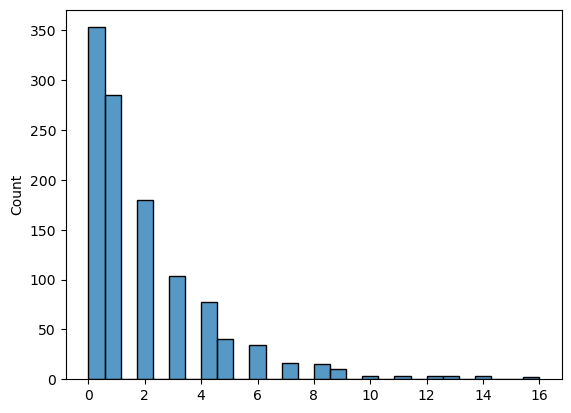

In [16]:
import seaborn as sns 

lengths =  [len(x) for x in docs]
# Build the histogram, distribution of lemmas in the texts
sns.histplot(lengths)

In [17]:
from gensim.models import CoherenceModel

# Defining dictionary and corpus with Gensim
dictionary = corpora.Dictionary(docs)
dictionary.add_documents(colocaciones)  # Agregar n-gramas al diccionario

corpus = [dictionary.doc2bow(text) for text in docs]

def calculate_coherence(dictionary, corpus, docs, start, stop):
    scores = []
    for topics in range(start, stop):

        # defining the model
        lda_model = LdaModel(corpus, id2word=dictionary, num_topics=20, alpha='auto', eval_every=5)

        # U_mass coherence score
        cm_u_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        u_mass_coherence = cm_u_mass.get_coherence()

        # C_v coherence score
        cm_c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
        c_v_coherence = cm_c_v.get_coherence()

        values = [topics, u_mass_coherence, c_v_coherence]

        scores.append(values)

    return scores

# calculare scores
scores = calculate_coherence(dictionary, corpus, docs, 5, 20)
scores

[[5, -18.84196199846714, 0.5791789884827689],
 [6, -18.602696584047386, 0.5563514658722581],
 [7, -18.949545548293152, 0.5839311949083208],
 [8, -18.608112763105648, 0.560879310418557],
 [9, -18.72651867594653, 0.5724361466081573],
 [10, -18.491453285904445, 0.5577806865910352],
 [11, -18.5394614698695, 0.5733302006307103],
 [12, -19.002431005773794, 0.5905065313512268],
 [13, -18.682950090578444, 0.575760347351106],
 [14, -18.856532616888565, 0.5795414094069131],
 [15, -18.332810608058164, 0.5443631658270869],
 [16, -18.27094380914085, 0.5387138629275083],
 [17, -18.852517895753415, 0.5782243358814992],
 [18, -18.740066955472578, 0.5697809095162171],
 [19, -18.69305293692014, 0.5722937304367829]]

Text(0.5, 1.0, 'u_mass coherence')

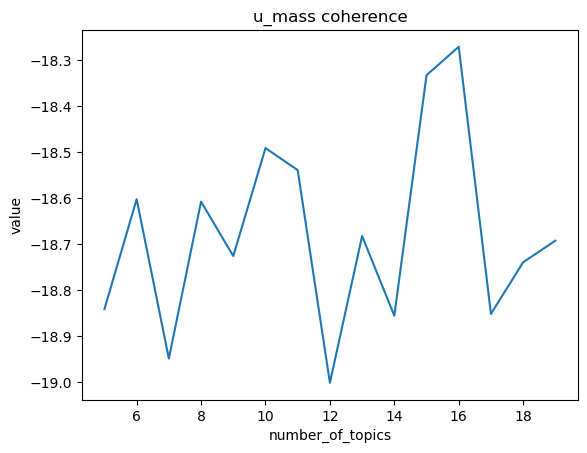

In [18]:
# scores to df
df = pd.DataFrame(scores, columns = ['number_of_topics','u_mass_coherence','c_v_coherence'])

# tidying the df
df = df.melt(id_vars=['number_of_topics'], value_vars=['u_mass_coherence','c_v_coherence'])

# Plotting u_mass_coherence
sns.lineplot(data=df.loc[df['variable'] == 'u_mass_coherence'], x="number_of_topics", y="value").set_title('u_mass coherence')

Text(0.5, 1.0, 'c_v coherence')

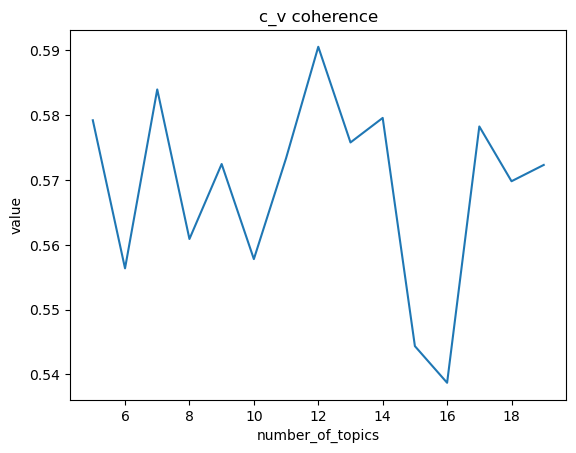

In [19]:
# Plotting c_v_coherence
sns.lineplot(data=df.loc[df['variable'] == 'c_v_coherence'], x="number_of_topics", y="value").set_title('c_v coherence')

In [20]:
lda_model = LdaModel(corpus, id2word=dictionary, num_topics=12, alpha='auto', eval_every=5, passes=15)

# print topics
topics = lda_model.print_topics(-1)

# Mostrar los temas y sus palabras clave
for topic in topics:
    print(topic)

(0, '0.030*"deber" + 0.028*"transformación" + 0.028*"cambio" + 0.024*"jalisco" + 0.024*"chemo" + 0.020*"presidente" + 0.016*"dedazo" + 0.012*"paz" + 0.012*"puebla" + 0.012*"proceso"')
(1, '0.043*"chayote" + 0.024*"presidenta" + 0.019*"fuerza" + 0.019*"seguro" + 0.018*"par" + 0.015*"denuncia" + 0.015*"partido" + 0.015*"lacra" + 0.015*"gobernador" + 0.015*"candidato"')
(2, '0.085*"jalisco" + 0.035*"respuesta" + 0.027*"amigo" + 0.024*"ruta" + 0.024*"narco" + 0.021*"gobernador" + 0.018*"alianza" + 0.017*"edificio" + 0.016*"mujer" + 0.014*"exacto"')
(3, '0.053*"gente" + 0.043*"dr" + 0.029*"jalisco" + 0.022*"gobierno" + 0.018*"mano" + 0.015*"apoyo" + 0.015*"historia" + 0.015*"cambio" + 0.011*"administración" + 0.011*"semana"')
(4, '0.072*"gobernador" + 0.071*"candidato" + 0.024*"mc" + 0.022*"morena" + 0.020*"paso" + 0.015*"cárcel" + 0.010*"cosa" + 0.010*"cariño" + 0.010*"palabra" + 0.010*"muestra"')
(5, '0.039*"voto" + 0.035*"comentario" + 0.022*"agua" + 0.021*"jalisco" + 0.018*"mc" + 0.013*

In [21]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
viz


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.155956 -0.140628       1        1  10.279814
9      0.093522 -0.068690       2        1   9.882540
2     -0.066721  0.104133       3        1   9.532289
3     -0.101668 -0.017042       4        1   9.329219
11    -0.051454 -0.027712       5        1   9.084272
7      0.015761 -0.073438       6        1   8.605792
6      0.055862 -0.063817       7        1   8.415041
0     -0.018232  0.170928       8        1   8.251157
5     -0.066561  0.090791       9        1   7.274740
1      0.122953 -0.007555      10        1   6.568856
4      0.098320  0.026600      11        1   6.448575
10     0.074174  0.006431      12        1   6.327704, topic_info=           Term       Freq      Total Category  logprob  loglift
5      corrupto  14.000000  14.000000  Default  30.0000  30.0000
107    encuesta  14.000000  14.000000  Default  29.0000  29.0000
46      jalisco  43.000000  43.000000  Default  28.0000  28.0000
210  gobernador  18.000000  18.000000  Default  27.0000  27.0000
44    candidato  26.000000  26.000000  Default  26.0000  26.0000
..          ...        ...        ...      ...      ...      ...
18   honestidad   2.003117   4.964246  Topic12  -4.2426   1.8527
22      persona   1.623066   8.621561  Topic12  -4.4530   1.0903
537      fuerza   1.421817   4.810204  Topic12  -4.5854   1.5414
480         ine   1.421816   6.446496  Topic12  -4.5854   1.2486
24       semana   1.420550   8.750400  Topic12  -4.5863   0.9422

[564 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
691       6  0.925771        2012
544       6  0.925769     abogada
621       7  0.692864     acarreo
641       6  0.695411  aceptación
660       8  0.701322   activista
...     ...       ...         ...
435      10  0.480669     yolanda
550      10  0.480668      zapato
111       3  0.924194         zmg
424       8  0.702667       ánimo
785       5  0.694030       órden

[719 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 10, 3, 4, 12, 8, 7, 1, 6, 2, 5, 11])

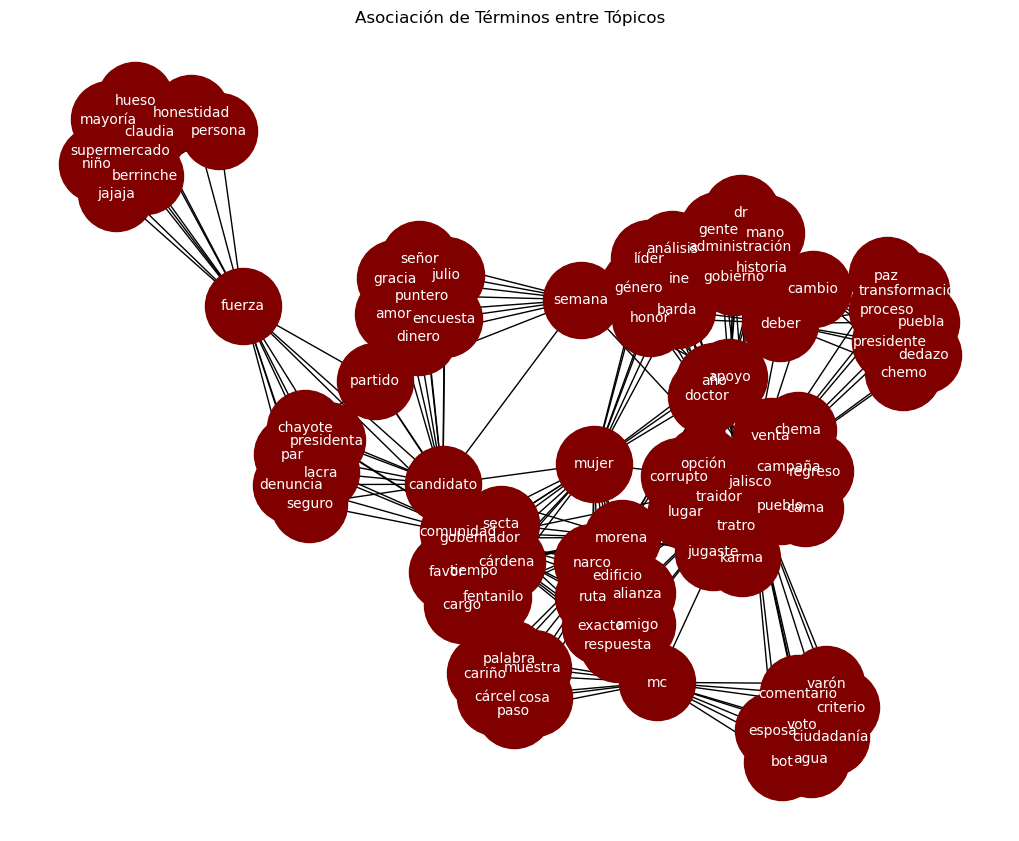

In [22]:
import networkx as nx

# Crear un grafo de red
G = nx.Graph()

# Procesar los tópicos y sus palabras clave para identificar asociaciones
for topic_id, topic_words in topics:
    # Dividir las palabras clave en términos individuales
    terms = [term.split('*')[1].strip('"') for term in topic_words.split(' + ')]
    
    # Agregar una arista entre todos los términos del tópico
    for i in range(len(terms)):
        for j in range(i + 1, len(terms)):
            term1, term2 = terms[i], terms[j]
            G.add_edge(term1, term2, topic=topic_id)

# Dibujar el gráfico de red
pos = nx.spring_layout(G, k=0.3, iterations=50)
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, font_size=10, node_size=3000, node_color='maroon', font_color='white')

# Mostrar el gráfico de red
plt.title('Asociación de Términos entre Tópicos')
# Guardar la figura como una imagen
plt.savefig('topicos.png', bbox_inches='tight', dpi=300)
plt.show()

In [23]:
# Función para obtener solo las palabras de un texto
def obtener_palabras(texto):
    palabras = re.findall(r'"([^"]*)"', texto)
    return palabras

# Aplicar la función a cada elemento del arreglo
solo_palabras = [(indice, obtener_palabras(texto)) for indice, texto in topics]

topicos = pd.DataFrame(solo_palabras,  columns=['No. Topico', 'Palabras Clave'])
topicos.head()

,No. Topico,Palabras Clave
0,0,"[deber, transformación, cambio, jalisco, chemo..."
1,1,"[chayote, presidenta, fuerza, seguro, par, den..."
2,2,"[jalisco, respuesta, amigo, ruta, narco, gober..."
3,3,"[gente, dr, jalisco, gobierno, mano, apoyo, hi..."
4,4,"[gobernador, candidato, mc, morena, paso, cárc..."


In [25]:
import dash
import dash_core_components as dcc
import dash_html_components as html
import pandas as pd
import dash_table
import dash_table



app = dash.Dash(__name__)

app.layout = html.Div([
    dash_table.DataTable(
        id='table',
        columns=[{"name": col, "id": col} for col in topicos.columns],
        data=topicos.to_dict('records'),
        editable=True,
        export_format='csv',  # Agrega esta opción para exportar los datos
        style_table={'overflowX': 'scroll'},  # Permite desplazarse horizontalmente
    ),
])


if __name__ == '__main__':
    app.run(jupyter_mode="external")


Dash app running on http://127.0.0.1:8050/


In [26]:
topicos

,No. Topico,Palabras Clave
0,0,"[deber, transformación, cambio, jalisco, chemo..."
1,1,"[chayote, presidenta, fuerza, seguro, par, den..."
2,2,"[jalisco, respuesta, amigo, ruta, narco, gober..."
3,3,"[gente, dr, jalisco, gobierno, mano, apoyo, hi..."
4,4,"[gobernador, candidato, mc, morena, paso, cárc..."
5,5,"[voto, comentario, agua, jalisco, mc, varón, e..."
6,6,"[mujer, año, ine, líder, deber, doctor, género..."
7,7,"[cárdena, mujer, candidato, tiempo, favor, com..."
8,8,"[chema, doctor, campaña, pueblo, jalisco, more..."
9,9,"[encuesta, candidato, amor, semana, dinero, pa..."
